## Load Dependencies

In [1]:
import logging
import math
import os

logging.basicConfig(level=logging.INFO)
logging.info("library loading")
logging.info("DEBUG")

import torch
import librosa

torch.set_grad_enabled(True)

import cached_conv as cc
import gin
import nn_tilde
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from absl import flags, app

import sys, os
try:
    import rave
except:
    import sys, os 
    sys.path.append(os.path.abspath('.'))
    import rave

import rave.core
import rave.dataset
from rave.transforms import get_augmentations, add_augmentation
import rave.blocks
import rave.resampler
import IPython.display as ipd
from rave.blocks import upsample

from torchsummary import summary

INFO:root:library loading
INFO:root:DEBUG


  [INFO]: device is not None, use cuda:0
  [INFO]    > call by:torchfcpe.tools.spawn_infer_cf_naive_mel_pe_from_pt
  [WARN] args.model.use_harmonic_emb is None; use default False
  [WARN]    > call by:torchfcpe.tools.spawn_cf_naive_mel_pe


## Load Pretrained Model

In [2]:
#Model path
run = "pretrained/non-causal"

cc.use_cached_conv(False)

In [14]:
ema_weights = True

gin.parse_config_file(os.path.join(run, "config.gin"))
checkpoint = rave.core.search_for_run(run)
print("loading checkpoint:", checkpoint)

pretrained = rave.RAVE()
    
if checkpoint is not None:
    checkpoint = torch.load(checkpoint, map_location='cuda')
    if ema_weights is True and "EMA" in checkpoint["callbacks"]:
        pretrained.load_state_dict(
            checkpoint["callbacks"]["EMA"],
            strict=False,
        )
    else:
        pretrained.load_state_dict(
            checkpoint["state_dict"],
            strict=False,
        )
else:
    print("No checkpoint found, RAVE will remain randomly initialized")

pretrained.eval()
pitch_enc = pretrained.pitch_encoder
pitch_enc.load_state_dict(torch.load(f"rave/utils/noncaus2048_mb6.pth", weights_only=True))
pretrained.pitch_encoder = pitch_enc

x = torch.rand(1, 1, 2**17)
y = torch.rand(1, 2**17)
emb = torch.rand(1, 2)
i_id = 'Trumpet'
pretrained(x, inst_id=['Trumpet'])

for m in pretrained.modules():
    if hasattr(m, "weight_g"):
        nn.utils.remove_weight_norm(m)

loading checkpoint: pretrained/non-causal/latest.ckpt


## Load test audio and visualize the trained F0 encoder

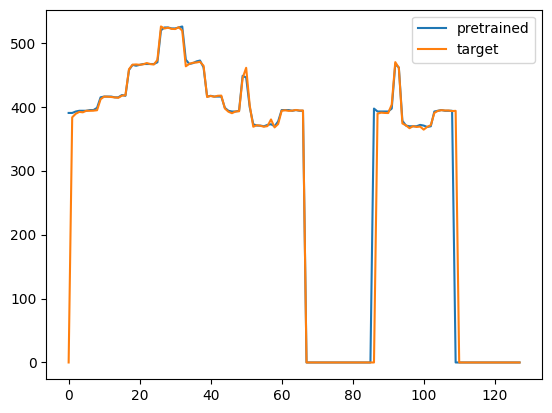

In [16]:
from rave.core import bins_to_frequency, entropy, extract_pitch, threshold
import matplotlib.pyplot as plt

x1, sr = librosa.load("audio/in_sing.wav", sr=44100, mono=True)
x1 = torch.tensor(x1[:2*131072]).unsqueeze(0).unsqueeze(0).float()

x2, sr = librosa.load("audio/trumpet_test.wav", sr=44100, mono=True)
x2 = torch.tensor(x2[:(2*131072)]).unsqueeze(0).unsqueeze(0).float()

# ------------------------------------------------------------------

p_fcpe = extract_pitch(x2.squeeze(1), sr=44100, block_size=2048)
x_mb = pretrained.pqmf(x2)

logits = pretrained.pitch_encoder(x_mb[:, :6, :])
pitch = torch.argmax(logits, dim=1)
pitch = bins_to_frequency(pitch)
periodicity = entropy(logits)
uv = threshold(periodicity)

plt.plot(pitch[0] * uv[0], label='pretrained')
plt.plot(p_fcpe[0].detach().cpu(), label='target')
plt.legend()

## Perform transfer

In [5]:
#Target instrument
emb_id = ['Trumpet']

#Pitch shift
p_mult = 1.0

In [6]:
output, harm, _, noise = pretrained(x1, inst_id=emb_id, p_mult=p_mult)

print("INPUT")
ipd.display(ipd.Audio(x1.detach().cpu().numpy()[0, 0, :], rate=sr))

print("TRANSFER")
ipd.display(ipd.Audio(output.detach().cpu().numpy()[0, 0, :], rate=sr))

print("EXCITATION")
ipd.display(ipd.Audio(harm.detach().cpu().numpy()[0, 0, :], rate=sr))

INPUT


TRANSFER


EXCITATION


## Perform transfer on a set on targets

In [7]:
GLOB_INST = ['Bassoon', 'Cello', 'Clarinet', 'Flute', 'Horn', 'Oboe', 'Saxophone', 'Trombone', 'Trumpet', 'Violin']

print("INPUTS")
ipd.display(ipd.Audio(x1.detach().cpu().numpy()[0, 0, :], rate=sr))
ipd.display(ipd.Audio(x2.detach().cpu().numpy()[0, 0, :], rate=sr))

print("VIOLIN")
emb_id = ['Violin']
output1, _, _, _ = pretrained(x1, inst_id=emb_id, p_mult=p_mult)
output2, _, _, _ = pretrained(x2, inst_id=emb_id, p_mult=p_mult)
ipd.display(ipd.Audio(output1.detach().cpu().numpy()[0, 0, :], rate=sr))
ipd.display(ipd.Audio(output2.detach().cpu().numpy()[0, 0, :], rate=sr))

print("CLARINET")
emb_id = ['Clarinet']
output1, _, _, _ = pretrained(x1, inst_id=emb_id, p_mult=p_mult)
output2, _, _, _ = pretrained(x2, inst_id=emb_id, p_mult=p_mult)
ipd.display(ipd.Audio(output1.detach().cpu().numpy()[0, 0, :], rate=sr))
ipd.display(ipd.Audio(output2.detach().cpu().numpy()[0, 0, :], rate=sr))

print("TRUMPET")
emb_id = ['Trumpet']
output1, _, _, _ = pretrained(x1, inst_id=emb_id, p_mult=p_mult)
output2, _, _, _ = pretrained(x2, inst_id=emb_id, p_mult=p_mult)
ipd.display(ipd.Audio(output1.detach().cpu().numpy()[0, 0, :], rate=sr))
ipd.display(ipd.Audio(output2.detach().cpu().numpy()[0, 0, :], rate=sr))

INPUTS


VIOLIN


CLARINET


TRUMPET


## Visualize embedding space and learned excitations

/tmp/ipykernel_362492/1923044246.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


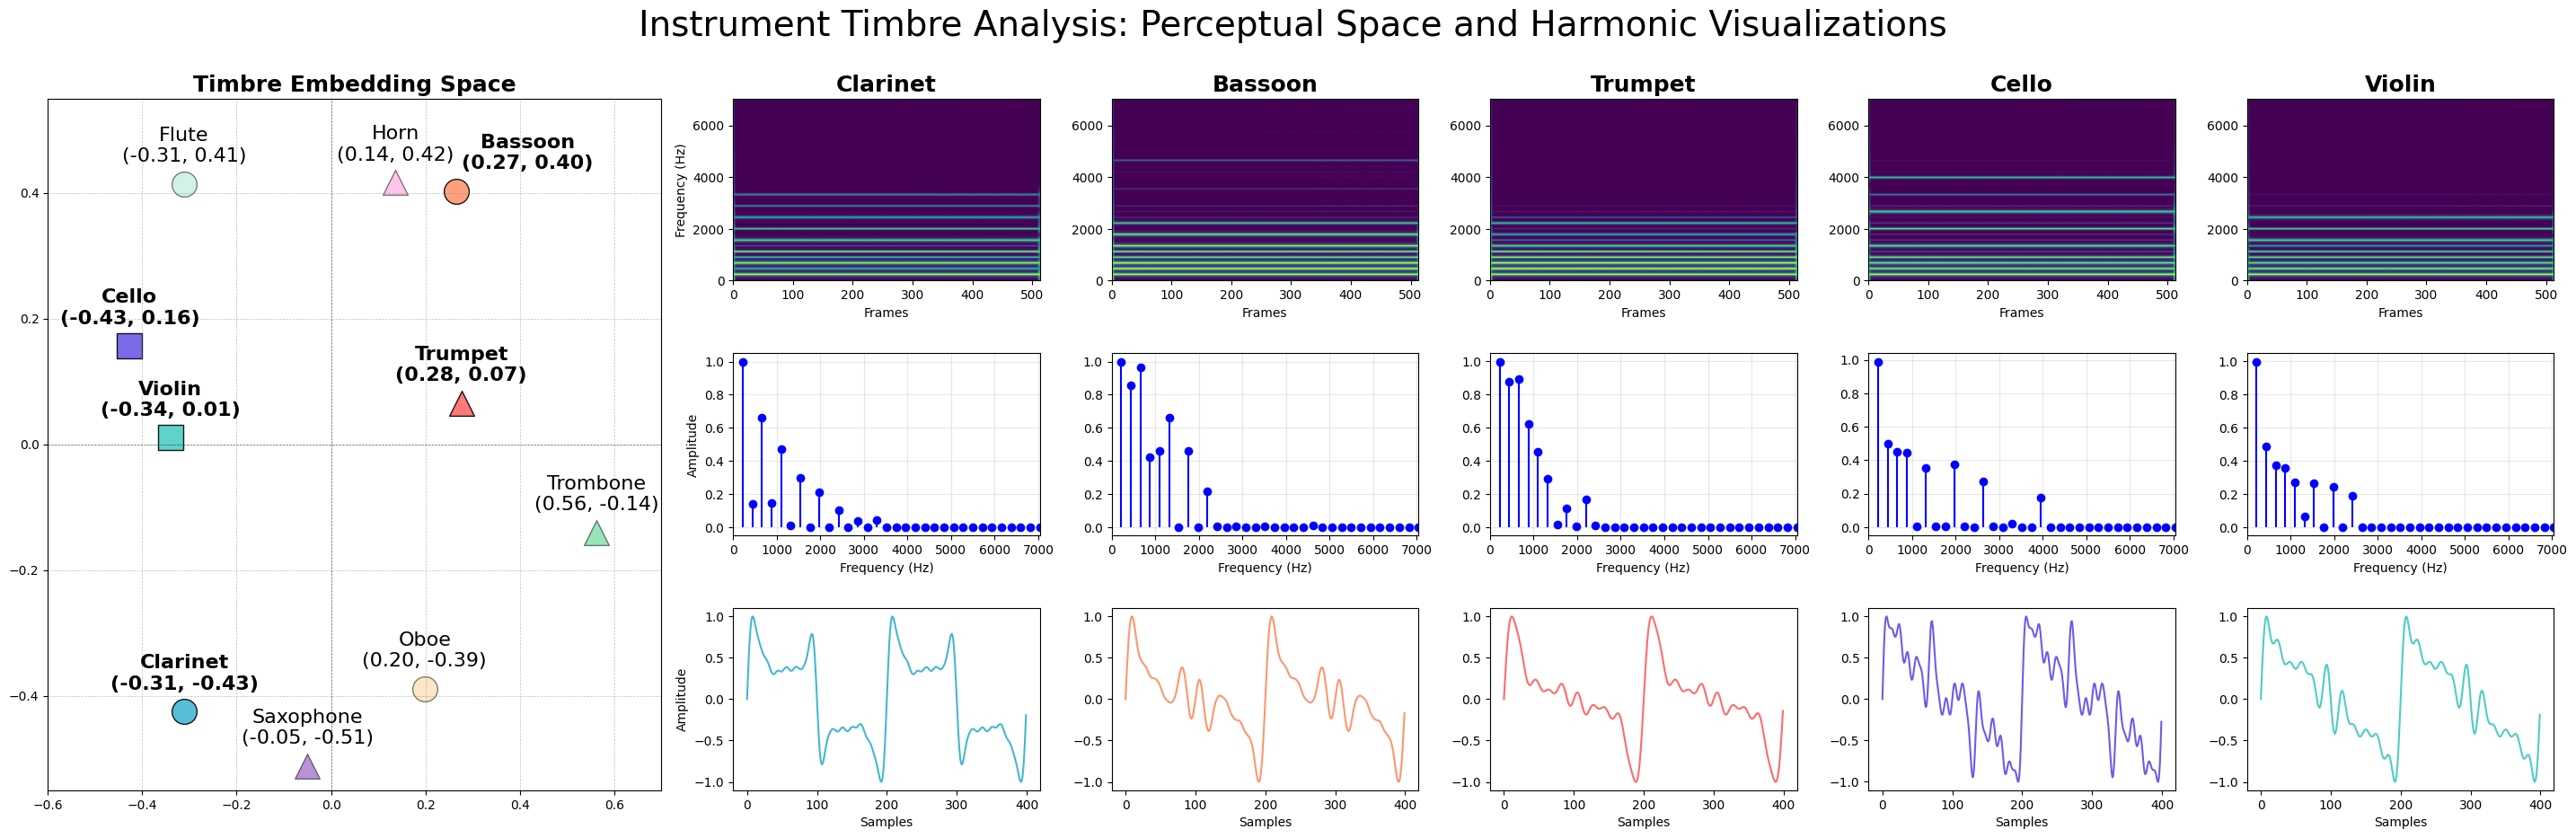

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from rave.utils import perceptive 

# Parameters Sine Input
sample_rate = 44100
f0 = 220  
num_samples = 131072
num_samples_waveform = 400 
num_harmonics = 32

t_long = torch.linspace(0, num_samples / sample_rate, steps=num_samples)
t_short = torch.linspace(0, num_samples_waveform / sample_rate, steps=num_samples_waveform)
sine_wave = torch.sin(2 * torch.pi * f0 * t_long).unsqueeze(0).unsqueeze(0) * 0.2 # Shape: [1, 1, num_samples]

#Parameters figure
font_size = 16
font_size_subtitle = 18

#Parameters embeddings
classes = ['Bassoon', 'Cello', 'Clarinet', 'Flute', 'Horn', 'Oboe', 'Saxophone', 'Trombone', 'Trumpet', 'Violin']
viz_classes = ['Clarinet', 'Bassoon', 'Trumpet', 'Cello', 'Violin']

# Function to create custom scatter plot
def create_custom_scatter(ax, x, y, instrument, size=300, is_visualized=False):
    """
    Create unique shapes for different instruments with text positioned above the symbol
    """
    # Color palette
    colors = {
        'Trumpet': '#FF6B6B',      # Vibrant red
        'Violin': '#4ECDC4',        # Teal
        'Clarinet': '#45B7D1',      # Bright blue
        'Bassoon': '#fd976e',       # Warm yellow
        'Cello': '#6C5CE7',         # Purple
        'Flute': '#A8E6CF',         # Mint green
        'Horn': '#FF8ED4',          # Pink
        'Oboe': '#FAD390',          # Light orange
        'Saxophone': '#7126ab',     # Slate blue
        'Trombone': '#2ECC71'       # Emerald green
    }
    
    # Set opacity based on whether the instrument is visualized
    alpha = 0.9 if is_visualized else 0.5
    
    # Shape styles
    if instrument in ['Trumpet', 'Trombone', 'Horn', 'Saxophone']:
        # Triangles for brass instruments
        ax.scatter(x, y, s=size*2, c=colors[instrument], marker='^', alpha=alpha, edgecolors='black')
    elif instrument in ['Violin', 'Cello']:
        # Squares for string instruments
        ax.scatter(x, y, s=size*2, c=colors[instrument], marker='s', alpha=alpha, edgecolors='black')
    elif instrument in ['Clarinet', 'Oboe', 'Bassoon', 'Flute']:
        # Pentagons for woodwind instruments
        ax.scatter(x, y, s=size*2, c=colors[instrument], marker='o', alpha=alpha, edgecolors='black')
    else:
        # Circles for others
        ax.scatter(x, y, s=size*2, c=colors[instrument], marker='p', alpha=alpha, edgecolors='black')
    
    # Add instrument name ABOVE the symbol with coordinates
    if instrument in ['Bassoon']:
        ax.text(x+0.15, y+0.03, f"{instrument}\n({x:.2f}, {y:.2f})", 
            fontsize=font_size, 
            ha='center', va='bottom', 
            color='black', fontweight='bold' if is_visualized else 'normal')
    else:
        ax.text(x, y+0.03, f"{instrument}\n({x:.2f}, {y:.2f})", 
                fontsize=font_size, 
                ha='center', va='bottom', 
                color='black', fontweight='bold' if is_visualized else 'normal')
    
    return colors[instrument]

freq_limit = f0 * num_harmonics
n_fft = 2048
freq_bins = n_fft // 2 + 1
freqs = torch.linspace(0, sample_rate / 2, freq_bins)
max_bin = (freqs <= freq_limit).nonzero().max().item() + 1

fig = plt.figure(figsize=((len(viz_classes) * 6 + 4) + 2, 8 + 2))
gs = GridSpec(3, len(viz_classes) + 1, figure=fig, height_ratios=[1, 1, 1], 
              hspace=0.4, wspace=0.4, width_ratios=[2.0] + [1] * len(viz_classes))

embed_ax = fig.add_subplot(gs[:, 0])  # This spans all rows in the first column
embed_ax.set_title("Timbre Embedding Space", fontsize=font_size_subtitle, fontweight='bold')

mds_dims = 2
fullTimbreData = perceptive.get_perceptual_centroids(mds_dims, timbre_path='rave/utils/timbre.npy')
GLOB_LAB = list(fullTimbreData['instruments'])
GLOB_EMB = fullTimbreData['pos']
indices = [GLOB_LAB.index(i) for i in classes]
embeddings = torch.tensor(GLOB_EMB[indices], dtype=torch.float32)

instrument_colors = {}

for i, (x, y) in enumerate(embeddings):
    instrument = classes[i]
    is_visualized = instrument in viz_classes
    color = create_custom_scatter(embed_ax, x, y, instrument, size=200, is_visualized=is_visualized)
    instrument_colors[instrument] = color

embed_ax.axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
embed_ax.axvline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
embed_ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
embed_ax.set_xlim(-0.6, 0.7)
embed_ax.set_ylim(-0.55, 0.55)

spectrogram_img = None

# Process each class
for idx, c in enumerate(viz_classes):
    
    signal, harm, amp, _ = pretrained(sine_wave, [c])
    amp = amp.squeeze()  
    harmonic_signal_long = torch.zeros(num_samples)
    harmonic_signal_short = torch.zeros(num_samples_waveform)
    
    for i in range(num_harmonics):
        harmonic_freq = f0 * (i + 1)  # Integer multiples of f0
        harmonic_signal_long += amp[i] * torch.sin(2 * torch.pi * harmonic_freq * t_long)
        harmonic_signal_short += amp[i] * torch.sin(2 * torch.pi * harmonic_freq * t_short)
    
    harmonic_signal_short = harmonic_signal_short / harmonic_signal_short.max()
    instrument_color = instrument_colors[c]
    
    # 1. STFT Spectrogram (First row)
    ax1 = fig.add_subplot(gs[0, idx + 1])
    gs.update(wspace=0.2)
    
    stft_result = torch.stft(
        harmonic_signal_long,
        n_fft=n_fft,
        hop_length=256,
        win_length=2048,
        window=torch.hann_window(2048),
        return_complex=True
    )
    stft_magnitude = torch.abs(stft_result)[:max_bin]
    stft_magnitude = stft_magnitude.detach()
    
    img = ax1.imshow(
        torch.log1p(stft_magnitude).numpy(),
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[0, stft_magnitude.shape[1], 0, freq_limit]
    )
    spectrogram_img = img 
    
    ax1.set_title(f"{c}", fontsize=font_size_subtitle, fontweight='bold')
    if idx == 0:
        ax1.set_ylabel("Frequency (Hz)")
    ax1.set_xlabel("Frames")
    
    # 2. Harmonic Amplitudes (Second row)
    ax2 = fig.add_subplot(gs[1, idx + 1])
    
    harmonic_freqs = f0 * torch.arange(1, num_harmonics + 1)
    mask = harmonic_freqs <= freq_limit
    harmonic_freqs = harmonic_freqs[mask]
    harmonic_amps = amp[mask]
    
    ax2.stem(harmonic_freqs.numpy(), harmonic_amps.detach().numpy(), 
             basefmt=" ", linefmt="blue")
    
    ax2.set_xlabel("Frequency (Hz)")
    if idx == 0:
        ax2.set_ylabel("Amplitude")
    ax2.set_xlim([0, freq_limit])
    ax2.grid(True, alpha=0.3)
    
    # 3. Waveform (Third row)
    ax3 = fig.add_subplot(gs[2, idx + 1])
    ax3.plot(harmonic_signal_short.detach(), color=instrument_color)
    
    ax3.grid(False)
    ax3.set_xlabel("Samples")
    if idx == 0:
        ax3.set_ylabel("Amplitude")

plt.suptitle("Instrument Timbre Analysis: Perceptual Space and Harmonic Visualizations", fontsize=28, x=0.51, y=0.98)
plt.tight_layout()
plt.show()